 - Diana Zaray Corado #191025
 - Pablo Alejandro Méndez #19195
- Orlando Osberto Cabrera #19943
# Hoja de Trabajo 7 - Redes Neuronales Artificales  

In [6]:
# Librerias
import pandas as pd
import numpy as np
import scipy.stats as sp
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [7]:
# General variables
cuantitative = [
    'LotFrontage',
    'LotArea',
    'MiscVal',
	'WoodDeckSF',
    'OpenPorchSF',
    'EnclosedPorch',
    '3SsnPorch',
    'ScreenPorch',
    'PoolArea',
    'GarageArea',
    'GrLivArea',
    'LowQualFinSF',
    '2ndFlrSF',
    '1stFlrSF',
    'TotalBsmtSF',
    'BsmtUnfSF',
    'BsmtFinSF2',
    'BsmtFinSF1',
    'MasVnrArea',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
    'SalePrice',
]

# Exploración de los datos
Para el desarrollo de modelos de clasificación y de regresión lineal se cuenta con un conjunto de datos provisto por Kaggle, la cual es una comunidad en línea de científicos de datos, que permite encontrar conjuntos de datos para explorar y construir modelos. El data set a utilizar se conoce como *House Prices: Advance Regression Techniques*, el cual tiene tanto un conjunto de entrenamiento como un conjunto de prueba. En esta hoja se estar utilizando el conjunto de entrenamiento, que cuenta con 81 variables y 1460 observaciones, el cual a su vez un 70% de los datos se utilizará como entrenamiento y un 30% como prueba. 

Se omite el análisis exploratorio del conjunto de datos debido a que ya se ha presentado en hojas de trabajo anteriores 

In [8]:
train = pd.read_csv("./train.csv")
train_shape = train.shape

# Resumen de los datos
head = train.head().style.set_properties(**{'text-align': 'center'}) 
display(head)
del head

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


# Exploración de los datos
Para el desarrollo de modelos de clasificación y de regresión lineal se cuenta con un conjunto de datos provisto por Kaggle, la cual es una comunidad en línea de científicos de datos, que permite encontrar conjuntos de datos para explorar y construir modelos. El data set a utilizar se conoce como *House Prices: Advance Regression Techniques*, el cual tiene tanto un conjunto de entrenamiento como un conjunto de prueba. En esta hoja se estar utilizando el conjunto de entrenamiento, que cuenta con 81 variables y 1460 observaciones, el cual a su vez un 70% de los datos se utilizará como entrenamiento y un 30% como prueba. 

Se omite el análisis exploratorio del conjunto de datos debido a que ya se ha presentado en hojas de trabajo anteriores 

In [9]:
train = pd.read_csv("./train.csv")
train_shape = train.shape

# Resumen de los datos
head = train.head().style.set_properties(**{'text-align': 'center'}) 
display(head)
del head

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000


## Preprocesamiento
Para el preprocesamiento de los datos se procede a validar si existen observaciones con valores faltantes y se realiza un escalamentiento de los datos.

In [10]:
select_train = train[cuantitative]
# Asegurando que no existan valores nan o inf
select_train = select_train[~select_train.isin([np.nan, np.inf, -np.inf]).any(1)]

Por análisis realizados en hojas anteriores se sabe que los datos no siguen una distribución normal, por lo tal es necesario realizar una normalización o una estandarización para garantizar que ninguna variable que tenga rango de valores muy grandes sean más influeyentes en el modelo que aquellas con rango de valores más bajos. Sin embargo, para poder agregar la variable clasificadora, la estandarización se realizará antes de hacer la separación de los conjuntos de datos en entrenamiento y prueba. 

Si bien es muy común que al momento de hacer preprocesamiento de los datos se realice tratamiento de outliers, las redes neuronales, especialmente aquellas que son multicapa, debido a que es un proceso de varios pasos para hacer el *fit* a los datos, esto abre paso a que el modelo sea más flexible y disminuya el impacto de los outliers. Por otro lado, generalmente las funciones de activación, proveen una especia de "aplanamiento" lo cual le da la capacidad al modelo de tratar los *outliers* y de que estos no tengan un impacto significativo en el modelo. 

Por lo mencionado anteriormente, no se realizará ningún tipo de tratamiento de *outliers* además de para garantizar una comparación equitativa con los modelos realizados en otras hojas de trabajo.

## Conjunto de prueba y entrenamiento
Seleccione como variable respuesta la que creó con las categorías del precio de la casa.

### Agregando la variable objetivo al conjunto de datos
Debido a que la variable objetivo es categórica y las redes neuronales requieren que los datos sean numéricos, es necesario codificar las categorías mediante números. Para codificar las categorías se usaran los siguientes valores:
- Baratas: 1
- Intermedias: 10
- Caras: 100

In [11]:
# Agregando la nueva variable al data frame
conditions = [
    (select_train['SalePrice'] <= 171500),
    (select_train['SalePrice'] > 171500) & (select_train['SalePrice'] <= 295500),
    (select_train['SalePrice'] > 295500) 
    ]

values = [1, 10, 100]

select_train['HouseCategory'] = np.select(conditions, values)
del values, conditions

### Selección de variables
Para seleccionar las variables a utilizar dentro del modelo, se inició tomando en consideración únicamente las variables numéricas. Seguido a esto, se realizó una correlación entre todas las variables cuantitativas para poder analizar cuáles son las que influyen significativamente en el precio de venta y con base a esto se seleccionó el conjunto de *features* a utilizar.

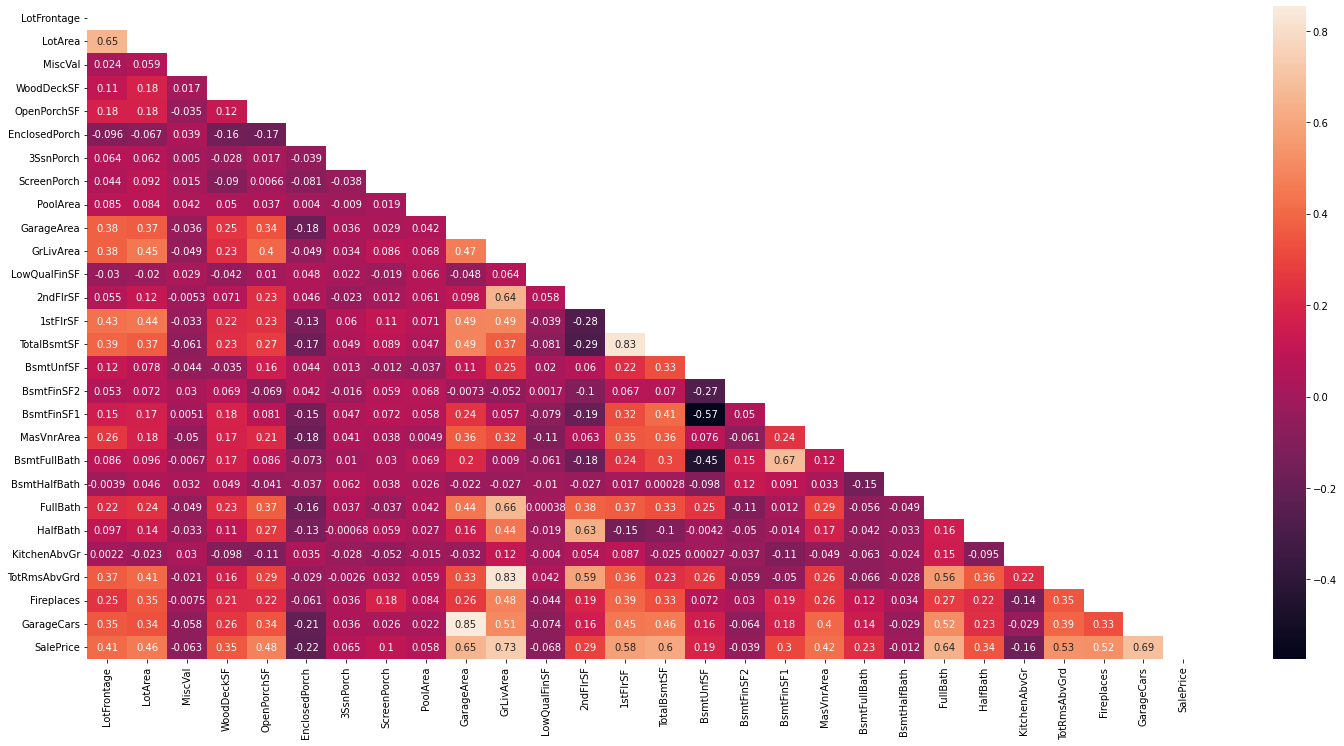

In [12]:
cuantitative_data = train[cuantitative]
correlation = cuantitative_data.corr(method = 'spearman')
plt.figure(figsize=(25,12))
matrix = np.triu(correlation)
sns.heatmap(correlation, annot=True, mask=matrix)
plt.show()

del correlation, cuantitative_data, matrix

Como se puede observar en la tabla y gráfica anterior se presentan aquellas variables que cuentan con una alta correlación (tomando como correlación alta a valores mayores o iguales a 0.5). A continuación se listan la correlaciones encontradas por variables:
- LotFrontage → LotArea
- GarageArea → GarageCars, SalePrice
- GrLivArea → 2ndFlrSF, FullBath, TotRmsAbvGrd, GarageCars, SalePrice
- 2ndFlrSF → HalfBath, TotRmsAbvGrd
- 1stFlrSF → TotalBsmtSF, SalePrice
- TotalBsmtSF → SalePrice
- BsmtUnfSF → BsmtFinSF1, BsmtFullBath
- FullBath → TotRmsAbvGrd, GarageCars, SalePrice
- TotRmsAbvGrd → SalePrice
- Fireplaces → SalePrice
- GargeCars → SalePrice

La estrecha correlación con la que cuentan las variables entre sí representa un potencial error para el modelo, ya que como bien se sabe, uno de los supuestos dentro del modelo de regresión logísticas es que las variables no presenten multicolinealidad ya que esto podría sesgar dicho modelo a la información "repetida" presentada por estas variables. Por lo tal, para evitar un sesgo y *overfitting* del modelo se eliminaran las variables correlacionadas, dejando solo una que represente la información de todas dentro del modelo. Las variables que se descartarán del modelo son:
- LotFrontage
- GarageCars
- TotRmsAbvGrd
- FullBath
- HalfBath
- TotalBsmtSF
- BsmtFinSF1
- BsmFullBath
- Fireplaces

In [13]:
useless = ['LotFrontage', 
'GarageCars', 
'TotRmsAbvGrd', 
'FullBath', 
'HalfBath', 
'TotalBsmtSF', 
'BsmtFinSF1', 
'BsmtFullBath', 
'Fireplaces', 
'PoolArea', 
'LowQualFinSF', 
'BsmtFinSF2', 
'BsmtHalfBath', 
'KitchenAbvGr' ]

In [14]:
selected_train = select_train.loc[:, ~select_train.columns.isin(useless)]

In [15]:
# separate between target and predictors
target = selected_train.pop('HouseCategory')
predictors = selected_train.copy()

In [16]:
# stratified sample
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, target, train_size  = 0.7, shuffle = True, random_state=19195)